# Journal Profiling Part 2: Impact Metrics

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [publications data ](https://docs.dimensions.ai/dsl/datasource-publications.html) for a specific journal, as well its authors and affiliations.

This tutorial is the second of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.


In this notebook we are going to:

* Load the researchers data previously extracted
* Enrich it by building a dataset focusing on their impact in terms of no of papers, citations etc.. 
* Visualize the results with plotly to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [1]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import os
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

DimCli v0.6.8.1 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Measuring the Impact of Researchers within a Journal

Goal: from the list of authors and publications we previously extracted, we want to create a new dataset focused on **researchers** with the following information:
* number of papers
* citations median 
* altmetric median 
* last publication year 

This data will allow to determine the 'impact' of a researcher within the journal.

### Load the publications and authors data previously saved

**NOTE** If you are using Google Colab or don't have the data available, just grab it [here](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data) and make sure they're saved in a folder called `journal-profile-data` where this notebook is. 

In [2]:
dfpubs = pd.read_csv(FOLDER_NAME+"/1_publications.csv")
authors = pd.read_csv(FOLDER_NAME+"/1_publications_authors.csv")

In [3]:
# replace empty values with 0 so to allow bulk calculations
dfpubs = dfpubs.fillna(0)
authors = authors.fillna(0)

### Isolate the Researchers data (= authors with an ID)

In [4]:
researchers = authors.query("researcher_id!=0")
print("Researchers total:",  len(researchers))
researchers.head(10)

Researchers total: 33377


,first_name,last_name,initials,corresponding,orcid,current_organization_id,researcher_id,affiliations,is_bogus,pub_id
48,Julien,Bryois,0.0,0,['0000-0002-4747-2166'],grid.4714.6,ur.0666011146.86,"[{'id': 'grid.4714.6', 'name': 'Karolinska Ins...",0,pub.1127148454
49,Nathan G.,Skene,0.0,0,['0000-0002-6807-3180'],grid.4714.6,ur.0720776104.57,"[{'id': 'grid.4714.6', 'name': 'Karolinska Ins...",0,pub.1127148454
52,Hunna J.,Watson,0.0,0,['0000-0001-8405-381X'],grid.10698.36,ur.01330130651.90,"[{'id': 'grid.10698.36', 'name': 'University o...",0,pub.1127148454
53,Zijing,Liu,0.0,0,0,grid.7445.2,ur.016105221567.82,"[{'id': 'grid.7445.2', 'name': 'Imperial Colle...",0,pub.1127148454
57,Leo,Brueggeman,0.0,0,['0000-0002-3586-3442'],grid.214572.7,ur.01254266166.55,"[{'id': 'grid.214572.7', 'name': 'University o...",0,pub.1127148454
58,Gerome,Breen,0.0,0,['0000-0003-2053-1792'],grid.13097.3c,ur.0654201533.32,"[{'id': 'grid.13097.3c', 'name': ""King's Colle...",0,pub.1127148454
59,Cynthia M.,Bulik,0.0,0,['0000-0001-7772-3264'],grid.10698.36,ur.01104743131.27,"[{'id': 'grid.4714.6', 'name': 'Karolinska Ins...",0,pub.1127148454
60,Ernest,Arenas,0.0,0,['0000-0003-0197-6577'],grid.4714.6,ur.0611665665.63,"[{'id': 'grid.4714.6', 'name': 'Karolinska Ins...",0,pub.1127148454
61,Jens,Hjerling-Leffler,0.0,True,['0000-0002-4539-1776'],grid.4714.6,ur.01014226210.16,"[{'id': 'grid.4714.6', 'name': 'Karolinska Ins...",0,pub.1127148454
62,Patrick F.,Sullivan,0.0,True,['0000-0002-6619-873X'],grid.10698.36,ur.015012714437.80,"[{'id': 'grid.4714.6', 'name': 'Karolinska Ins...",0,pub.1127148454


### Enrich the data with Impact Statistics

First, let's pivot on the researcher ID field to eliminate duplicates and count them 

In [5]:
researchers_impact = researchers[['researcher_id', 'pub_id']].groupby('researcher_id', as_index=False).count().sort_values(by=['pub_id'], ascending=False).reset_index(drop=True)
researchers_impact.rename(columns={"pub_id": "pubs"}, inplace=True)
researchers_impact.head(10)

,researcher_id,pubs
0,ur.0723426172.10,62
1,ur.01277776417.51,45
2,ur.01247426430.47,33
3,ur.01313145634.66,32
4,ur.01317433110.75,32
5,ur.0641525362.39,31
6,ur.01264737414.70,30
7,ur.014377465057.81,28
8,ur.0637651205.48,28
9,ur.01220453202.22,27


Second, for each researcher ID we can query all of his/her publications so to calculate the following metrics: 

* citations median 
* altmetric median 
* last publication year 

Also, we add a new field with the Dimensions URL of the researcher, as it can be handy later on to open up its profile page online.


In [6]:

def get_name_surname(researcher_id):
    """
    eg
    >>> get_name_surname("ur.0723426172.10")
    'Kari Stefansson'
    """
    q = "researcher_id=='%s'" % researcher_id
    x = researchers.query(q)['first_name'].value_counts().idxmax()
    y = researchers.query(q)['last_name'].value_counts().idxmax()
    return f"{x} {y}"


# def dimensions_url(researcher_id):
#     return f"https://app.dimensions.ai/discover/publication?and_facet_researcher={researcher_id}"

fullnames, citations, altmetric, last_year, urls = [], [], [], [], []

for i, row in progress(researchers_impact.iterrows(), total=researchers_impact.shape[0]):
    q = "researcher_id=='%s'" % row['researcher_id']
    pub_ids = list(researchers.query(q)['pub_id'])
    fullnames.append(get_name_surname(row['researcher_id']))
    citations.append(dfpubs[dfpubs['id'].isin(pub_ids)]['times_cited'].mean())
    altmetric.append(dfpubs[dfpubs['id'].isin(pub_ids)]['altmetric'].mean())
    last_year.append(dfpubs[dfpubs['id'].isin(pub_ids)]['year'].max())
    urls.append(dimensions_url(row['researcher_id']))

researchers_impact['full_name'] = fullnames
researchers_impact['citations_mean'] = citations
researchers_impact['altmetric_mean'] = altmetric
researchers_impact['last_pub_year'] = last_year
researchers_impact['url'] = urls
# finally..
print("Researchers total:",  len(researchers_impact))
researchers_impact.head(10)


Researchers total: 18524


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,62,Kari Stefansson,107.516129,229.129032,2020,https://app.dimensions.ai/discover/publication...
1,ur.01277776417.51,45,Unnur Thorsteinsdottir,81.000000,159.555556,2019,https://app.dimensions.ai/discover/publication...
2,ur.01247426430.47,33,Gudmar Thorleifsson,80.818182,170.424242,2019,https://app.dimensions.ai/discover/publication...
3,ur.01313145634.66,32,Andres Metspalu,170.562500,362.875000,2019,https://app.dimensions.ai/discover/publication...
4,ur.01317433110.75,32,Caroline Hayward,136.843750,298.468750,2020,https://app.dimensions.ai/discover/publication...
5,ur.0641525362.39,31,Gonçalo R Abecasis,126.548387,144.290323,2019,https://app.dimensions.ai/discover/publication...
6,ur.01264737414.70,30,Tõnu Esko,153.133333,346.000000,2020,https://app.dimensions.ai/discover/publication...
7,ur.014377465057.81,28,Benjamin M. Neale,247.250000,178.392857,2020,https://app.dimensions.ai/discover/publication...
8,ur.0637651205.48,28,Daniel F Gudbjartsson,73.250000,151.964286,2019,https://app.dimensions.ai/discover/publication...
9,ur.01220453202.22,27,Eleftheria Zeggini,74.222222,207.962963,2019,https://app.dimensions.ai/discover/publication...


Save the data

In [7]:
save(researchers_impact, "2_researchers_impact_metrics.csv")

## Couple of Dataviz

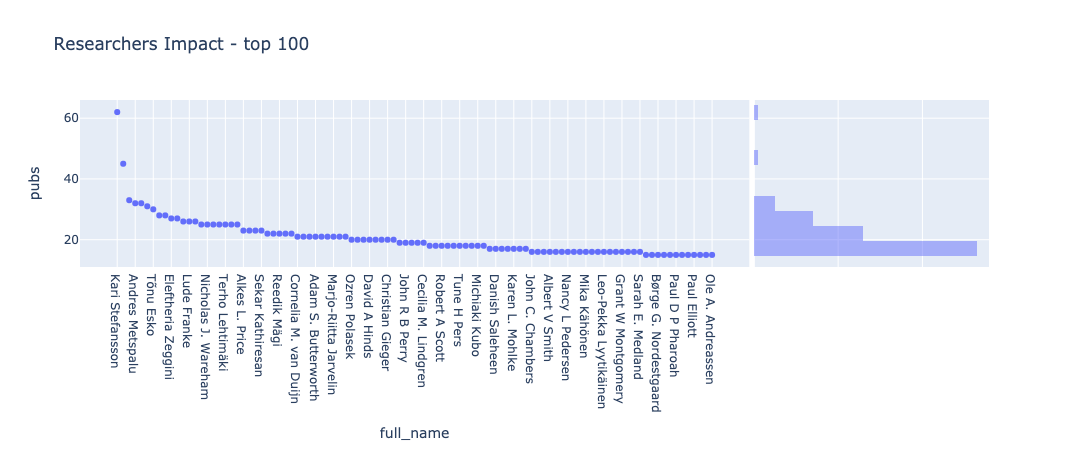

In [8]:
top100 = researchers_impact[:100]
px.scatter(top100, 
           x="full_name", y="pubs", 
           hover_name="full_name", 
           hover_data=['citations_mean', 'altmetric_mean'], 
           marginal_y="histogram", 
           title="Researchers Impact - top 100")

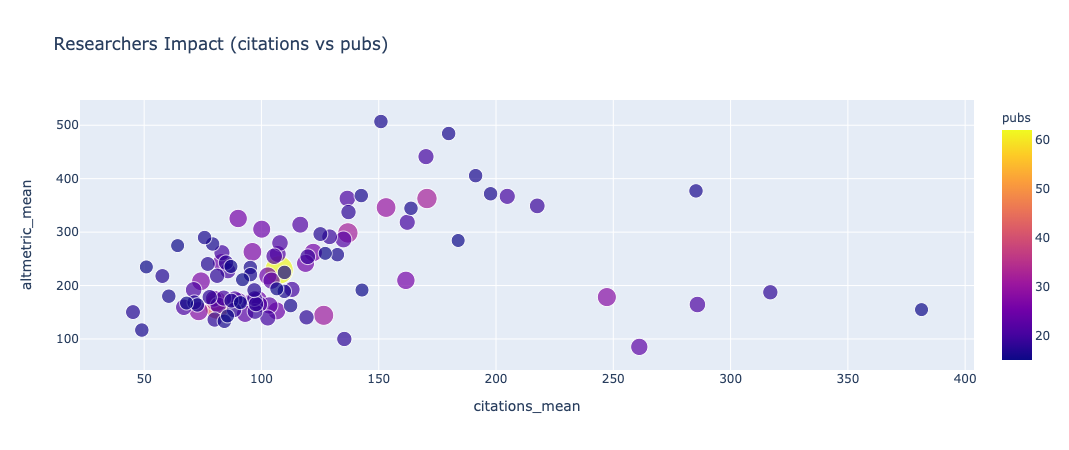

In [9]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           title="Researchers Impact (citations vs pubs)")

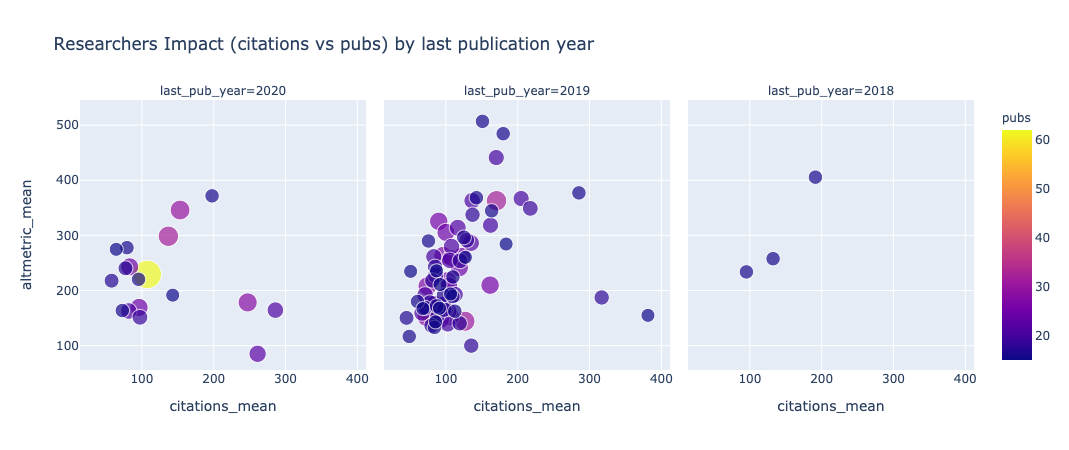

In [10]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           facet_col="last_pub_year",
           title="Researchers Impact (citations vs pubs) by last publication year")